In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import transforms
from torch.utils.data import Dataset
from typing import List, Tuple
from torch.utils.data import ConcatDataset
import numpy as np
import sys
sys.path.append('../')
from utils import BrainGraphDataset, project_root
import os
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import torch.nn.functional as F
import random
from models import VGAE

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# set the random seed for reproducibility
torch.manual_seed(0)

# define the hyperparameters
input_dim = 100  # size of the graph adjacency matrix
hidden_dim = 64
latent_dim = 4
lr = 1e-3
batch_size = 8
num_epochs = 500

annotations = 'annotations.csv'
dataroot = 'fc_matrices/psilo_schaefer_before/'
root = project_root()

dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=None, setting='lz')

# dataroot = 'fc_matrices/psilo_schaefer_after/'

# dataset_2 = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
#                             annotations_file=os.path.join(root, annotations),
#                             transform=None, extra_data=None, setting='lz')

# dataset = ConcatDataset([dataset, dataset_2])

# split the dataset into training and validation sets
num_samples = len(dataset)
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)
test_size =  num_samples - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# define the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


dropout_list = [0.3]

# define a dictionary to store the loss curves for each configuration
loss_curves = {}

edge_index = torch.triu(torch.ones((input_dim, input_dim)), diagonal=1).nonzero(as_tuple=False).t()
src, dest = edge_index

for dropout in dropout_list:
    best_val_loss = float('inf')  # set to infinity to start
    best_model_state = None
    train_losses = []
    val_losses = []
    model = VGAE(1, 1, input_dim, hidden_dim, latent_dim, device, dropout=dropout, l2_strength=0.1).to(device)  # move model to device
    print(model)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        val_loss = 0.0

        # training
        model.train()
        for batch_idx, ((graph, lz, _), _) in enumerate(train_loader):
            graph = graph.to(device)  # move data to device
            lz = lz.to(device)
            optimizer.zero_grad()

            rcn_lz, rcn_edges, node_reps = model(lz, graph)
            graph = graph[:, src, dest]

            (mse_loss, im_loss, l2_loss) = model.loss(rcn_lz.view(lz.shape), lz, rcn_edges.view(graph.shape), graph, node_reps)
            loss = mse_loss + im_loss + l2_loss
            loss.backward()
            
            optimizer.step()
            train_loss += mse_loss.item()
        # validation
        model.eval()
        with torch.no_grad():
            for batch_idx, ((graph, lz, _), _) in enumerate(val_loader):
                graph = graph.to(device)  # move data to device
                lz = lz.to(device)
                optimizer.zero_grad()

                rcn_lz, rcn_edges, node_reps = model(lz, graph)
                graph = graph[:, src, dest]
            
                (mse_loss, im_loss, l2_loss) = model.loss(rcn_lz.view(lz.shape), lz, rcn_edges.view(graph.shape), graph, node_reps)
                loss = mse_loss + im_loss + l2_loss
                val_loss += loss.item()
        # append losses to lists
        train_losses.append(train_loss/len(train_dataset))
        val_losses.append(val_loss/len(val_dataset))

        # save the model if the validation loss is at its minimum
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_state = model.state_dict().copy()

        # print the losses
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')

    print(f'Best val loss: {best_val_loss}')
    # save the best model for this configuration
    torch.save(best_model_state, os.path.join(root, f'vgae_weights/vgae_dropout_{dropout}.pt'))

cpu
VGAE(
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (lr): LeakyReLU(negative_slope=0.01)
    (sigmoid): Sigmoid()
    (fc1): Linear(in_features=102, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_nodes): Sequential(
      (0): Linear(in_features=400, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.3, inplace=False)
      (6): Linear(in_features=64, out_features=100, bias=True)
    )
    (decoder_edges): Sequential(
      (0): Linear(in_features=400, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): 

  2%|▏         | 10/500 [00:02<01:51,  4.40it/s]

Epoch 10/500 - Train Loss: 288.2268 - Val Loss: 256.8365



  4%|▍         | 20/500 [00:04<01:49,  4.38it/s]

Epoch 20/500 - Train Loss: 232.5841 - Val Loss: 227.2722



  6%|▌         | 30/500 [00:06<01:46,  4.40it/s]

Epoch 30/500 - Train Loss: 209.3960 - Val Loss: 234.5744



  8%|▊         | 40/500 [00:09<01:44,  4.40it/s]

Epoch 40/500 - Train Loss: 208.4016 - Val Loss: 224.4341



 10%|█         | 50/500 [00:11<01:43,  4.34it/s]

Epoch 50/500 - Train Loss: 192.8656 - Val Loss: 218.3304



 12%|█▏        | 60/500 [00:13<01:41,  4.32it/s]

Epoch 60/500 - Train Loss: 186.1710 - Val Loss: 207.8507



 14%|█▍        | 70/500 [00:16<01:39,  4.33it/s]

Epoch 70/500 - Train Loss: 177.6665 - Val Loss: 200.5893



 16%|█▌        | 80/500 [00:18<01:37,  4.32it/s]

Epoch 80/500 - Train Loss: 184.6988 - Val Loss: 201.2621



 18%|█▊        | 90/500 [00:20<01:35,  4.30it/s]

Epoch 90/500 - Train Loss: 177.1627 - Val Loss: 196.2425



 20%|██        | 100/500 [00:22<01:32,  4.31it/s]

Epoch 100/500 - Train Loss: 174.2489 - Val Loss: 196.7742



 22%|██▏       | 110/500 [00:25<01:30,  4.30it/s]

Epoch 110/500 - Train Loss: 173.4775 - Val Loss: 194.6781



 24%|██▍       | 120/500 [00:27<01:28,  4.30it/s]

Epoch 120/500 - Train Loss: 169.2935 - Val Loss: 193.0805



 26%|██▌       | 130/500 [00:29<01:25,  4.30it/s]

Epoch 130/500 - Train Loss: 172.4367 - Val Loss: 190.5447



 28%|██▊       | 140/500 [00:32<01:23,  4.30it/s]

Epoch 140/500 - Train Loss: 163.9844 - Val Loss: 193.5517



 30%|███       | 150/500 [00:34<01:21,  4.29it/s]

Epoch 150/500 - Train Loss: 156.7387 - Val Loss: 191.0871



 32%|███▏      | 160/500 [00:36<01:17,  4.36it/s]

Epoch 160/500 - Train Loss: 152.3273 - Val Loss: 185.6902



 34%|███▍      | 170/500 [00:39<01:15,  4.39it/s]

Epoch 170/500 - Train Loss: 148.1050 - Val Loss: 185.6284



 36%|███▌      | 180/500 [00:41<01:13,  4.38it/s]

Epoch 180/500 - Train Loss: 148.2399 - Val Loss: 181.5279



 38%|███▊      | 190/500 [00:43<01:10,  4.40it/s]

Epoch 190/500 - Train Loss: 143.9167 - Val Loss: 181.3724



 40%|████      | 200/500 [00:46<01:08,  4.38it/s]

Epoch 200/500 - Train Loss: 147.2666 - Val Loss: 180.5845



 42%|████▏     | 210/500 [00:48<01:06,  4.38it/s]

Epoch 210/500 - Train Loss: 141.1936 - Val Loss: 180.1457



 44%|████▍     | 220/500 [00:50<01:04,  4.37it/s]

Epoch 220/500 - Train Loss: 142.5601 - Val Loss: 180.0760



 46%|████▌     | 230/500 [00:52<01:01,  4.37it/s]

Epoch 230/500 - Train Loss: 133.3438 - Val Loss: 180.1458



 48%|████▊     | 240/500 [00:55<00:59,  4.37it/s]

Epoch 240/500 - Train Loss: 144.1204 - Val Loss: 187.1646



 50%|█████     | 250/500 [00:57<00:56,  4.39it/s]

Epoch 250/500 - Train Loss: 144.2097 - Val Loss: 178.8756



 52%|█████▏    | 260/500 [00:59<00:54,  4.41it/s]

Epoch 260/500 - Train Loss: 132.9213 - Val Loss: 181.3189



 54%|█████▍    | 270/500 [01:02<00:52,  4.39it/s]

Epoch 270/500 - Train Loss: 135.8078 - Val Loss: 179.5078



 56%|█████▌    | 280/500 [01:04<00:50,  4.39it/s]

Epoch 280/500 - Train Loss: 135.8539 - Val Loss: 182.8823



 58%|█████▊    | 290/500 [01:06<00:48,  4.37it/s]

Epoch 290/500 - Train Loss: 129.1592 - Val Loss: 178.6917



 60%|██████    | 300/500 [01:08<00:45,  4.37it/s]

Epoch 300/500 - Train Loss: 129.7228 - Val Loss: 185.3563



 62%|██████▏   | 310/500 [01:11<00:43,  4.38it/s]

Epoch 310/500 - Train Loss: 121.3669 - Val Loss: 184.3637



 64%|██████▍   | 320/500 [01:13<00:40,  4.41it/s]

Epoch 320/500 - Train Loss: 120.1120 - Val Loss: 183.8273



 66%|██████▌   | 330/500 [01:15<00:38,  4.40it/s]

Epoch 330/500 - Train Loss: 129.5108 - Val Loss: 189.0259



 68%|██████▊   | 340/500 [01:17<00:36,  4.38it/s]

Epoch 340/500 - Train Loss: 125.7325 - Val Loss: 184.1196



 70%|███████   | 350/500 [01:20<00:34,  4.40it/s]

Epoch 350/500 - Train Loss: 122.2878 - Val Loss: 186.3299



 72%|███████▏  | 360/500 [01:22<00:31,  4.39it/s]

Epoch 360/500 - Train Loss: 126.7847 - Val Loss: 181.4513



 74%|███████▍  | 370/500 [01:24<00:29,  4.38it/s]

Epoch 370/500 - Train Loss: 109.2587 - Val Loss: 192.7144



 76%|███████▌  | 380/500 [01:27<00:27,  4.38it/s]

Epoch 380/500 - Train Loss: 111.2035 - Val Loss: 185.6283



 78%|███████▊  | 390/500 [01:29<00:25,  4.30it/s]

Epoch 390/500 - Train Loss: 107.2786 - Val Loss: 188.3147



 80%|████████  | 400/500 [01:31<00:23,  4.31it/s]

Epoch 400/500 - Train Loss: 101.1722 - Val Loss: 188.2428



 82%|████████▏ | 410/500 [01:34<00:20,  4.30it/s]

Epoch 410/500 - Train Loss: 109.9034 - Val Loss: 191.9476



 84%|████████▍ | 420/500 [01:36<00:18,  4.31it/s]

Epoch 420/500 - Train Loss: 106.7019 - Val Loss: 190.6315



 86%|████████▌ | 430/500 [01:38<00:16,  4.26it/s]

Epoch 430/500 - Train Loss: 109.5626 - Val Loss: 193.5549



 88%|████████▊ | 440/500 [01:41<00:14,  4.25it/s]

Epoch 440/500 - Train Loss: 106.5769 - Val Loss: 194.5000



 90%|█████████ | 450/500 [01:43<00:11,  4.26it/s]

Epoch 450/500 - Train Loss: 106.0551 - Val Loss: 195.3952



 92%|█████████▏| 460/500 [01:45<00:09,  4.25it/s]

Epoch 460/500 - Train Loss: 100.8862 - Val Loss: 195.6222



 94%|█████████▍| 470/500 [01:48<00:07,  4.25it/s]

Epoch 470/500 - Train Loss: 98.6591 - Val Loss: 192.6217



 96%|█████████▌| 480/500 [01:50<00:04,  4.25it/s]

Epoch 480/500 - Train Loss: 106.2379 - Val Loss: 193.7298



 98%|█████████▊| 490/500 [01:52<00:02,  4.26it/s]

Epoch 490/500 - Train Loss: 100.8103 - Val Loss: 193.9712



100%|██████████| 500/500 [01:55<00:00,  4.34it/s]

Epoch 500/500 - Train Loss: 100.8074 - Val Loss: 191.2611

Best val loss: 177.04031372070312


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# set the random seed for reproducibility
torch.manual_seed(0)

# define the hyperparameters
input_dim = 100  # size of the graph adjacency matrix
hidden_dim = 256
latent_dim = 64
lr = 1e-3
batch_size = 64
num_epochs = 200

annotations = 'annotations.csv'
dataroot = 'fc_matrices/hcp_100_ica/'
cwd = os.getcwd() + '/'

dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=cwd + dataroot + annotations,
                            transform=None, extra_data=None, setting='lz')

dataroot = 'fc_matrices/psilo_ica_100_before/'
psilo_dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=cwd + annotations,
                            transform=None, extra_data=None, setting='lz')

psilo_train_loader = DataLoader(psilo_dataset, batch_size=batch_size)

train_dataset = dataset
val_dataset = psilo_dataset

# define the data loaders
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = psilo_train_loader

# define a dictionary to store the loss curves for each configuration
loss_curves = {}

edge_index = torch.triu(torch.ones((input_dim, input_dim)), diagonal=1).nonzero(as_tuple=False).t()
src, dest = edge_index

for latent_size in range(1,9):
    best_val_loss = float('inf')  # set to infinity to start
    best_model_state = None
    train_losses = []
    val_losses = []
    model = VGAE(1, 1, 100, 64, latent_size, device, dropout=0.05, l2_strength=0.001).to(device)  # move model to device
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        val_loss = 0.0

        # training
        model.train()
        for batch_idx, ((graph, lz, _), _) in enumerate(train_loader):
            graph = graph.to(device)  # move data to device
            lz = lz.to(device)
            optimizer.zero_grad()

            rcn_lz, rcn_edges, z = model(lz, graph)
            graph = graph[:, src, dest]

            (mse_loss, im_loss, l2_loss) = model.loss(rcn_lz.view(lz.shape), lz, rcn_edges.view(graph.shape), graph, z)
            loss = mse_loss + im_loss + l2_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # validation
        model.eval()
        with torch.no_grad():
            for batch_idx, ((graph, lz, _), _) in enumerate(val_loader):
                graph = graph.to(device)  # move data to device
                lz = lz.to(device)
                optimizer.zero_grad()

                rcn_lz, rcn_edges, z = model(lz, graph)
                graph = graph[:, src, dest]

                (mse_loss, im_loss, l2_loss) = model.loss(rcn_lz.view(lz.shape), lz, rcn_edges.view(graph.shape), graph, z)
                loss = mse_loss + im_loss + l2_loss
                val_loss += loss.item()
        # append losses to lists
        train_losses.append(train_loss/len(train_dataset))
        val_losses.append(val_loss/len(val_dataset))

        # save the model if the validation loss is at its minimum
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_state = model.state_dict().copy()

    # save the best model for this configuration
    torch.save(best_model_state, f'vgae_weights/vgae_latent_{latent_size}.pt')

    # add the loss curves to the dictionary
    loss_curves[f"latent_{latent_size}"] = {"train_loss": train_losses, "val_loss": val_losses}

# save the loss curves to a file
with open("loss_curves_vgae_latent_test.json", "w") as f:
    json.dump(loss_curves, f)

cpu


FileNotFoundError: [Errno 2] No such file or directory: '/rds/general/user/ljn19/home/big/container/psilocybrain/vgae_weights/fc_matrices/hcp_100_ica/annotations.csv'

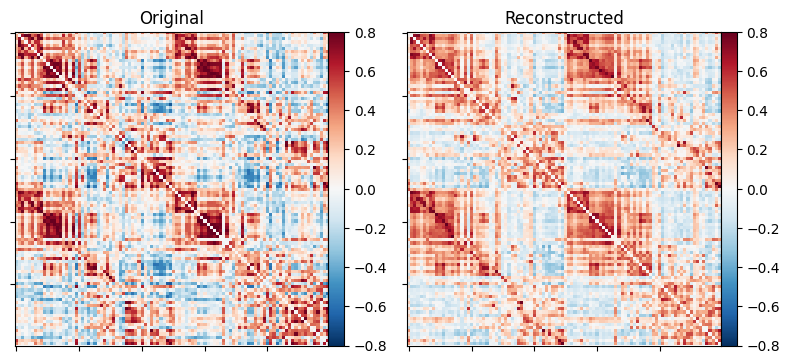

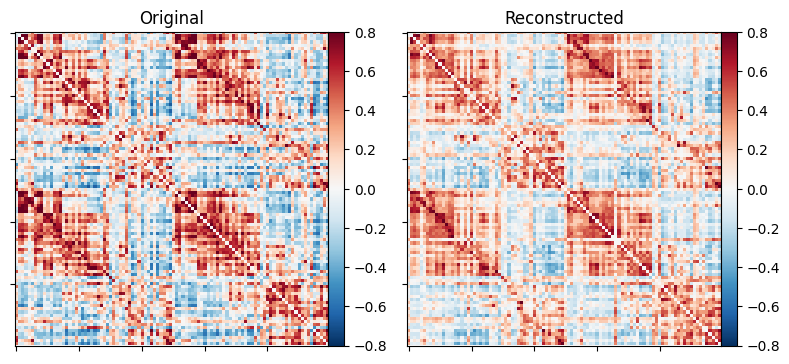

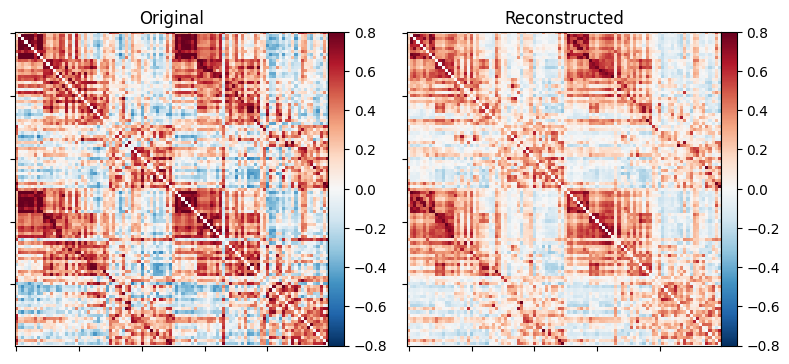

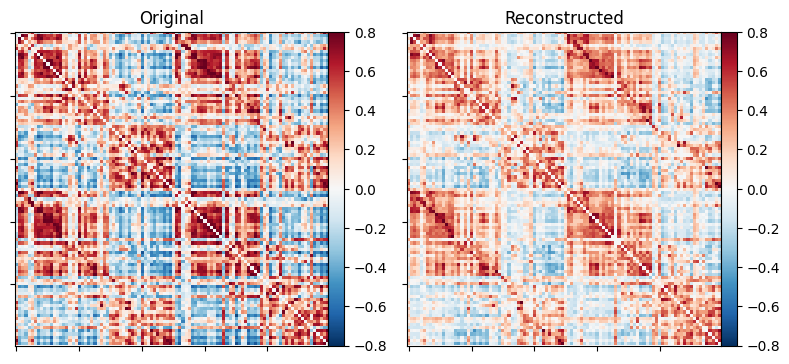

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

In [7]:
import matplotlib.pyplot as plt
from nilearn import plotting

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = VGAE(1, 1, 100, 64, 8, device, dropout=0.05, l2_strength=0.001).to(device)  # move model to device
# model.load_state_dict(torch.load(f'vgae_weights/vgae_first_working_0.05.pt', map_location=device))

# select a batch from the validation data loader
data, _ = next(iter(val_loader))

for j in range(min(batch_size, 5)):
    # pass the batch through the trained model to obtain the reconstructed output
    (graph, lz, _) = data
    graph = graph[j:j+1].to(device)
    lz = lz[j:j+1].to(device)

    recon_x, recon_edges, z = model(lz, graph)

    recon_edges = recon_edges.detach()

    # Create a SparseTensor object from the edge_index and edge_attr tensors
    recon = torch.zeros((100, 100))

    
    for i in range(edge_index.shape[1]):
        recon[edge_index[0,i], edge_index[1,i]] = recon_edges[0][i]
        recon[edge_index[1,i], edge_index[0,i]] = recon_edges[0][i]

    # reshape the output to a 100x100 matrix (assuming the input_dim is 100x100)

    # plot the original and reconstructed matrices for the first sample in the batch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    plotting.plot_matrix(graph.cpu().view(100, 100), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax1)
    ax1.set_title('Original')
    plotting.plot_matrix(recon.detach(), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax2)
    ax2.set_title('Reconstructed')
    plt.show()

In [ ]:
import json
import matplotlib.pyplot as plt

# load in the loss curves from file
with open("loss_curves_vgae_latent_test.json", "r") as f:
    loss_curves = json.load(f)

# plot the validation loss curves for each number of GMM components
plt.figure(figsize=(8, 6))
for n_comp, loss_dict in loss_curves.items():

    val_losses = loss_dict["val_loss"]
    epochs = range(1, len(val_losses) + 1)
    plt.plot(epochs, val_losses, label=f"{n_comp}")

# add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves for Different Dropouts")
plt.legend()
plt.ylim((0, 600))

# show the plot
plt.show()


In [ ]:
import json
import matplotlib.pyplot as plt

# load in the loss curves from file
with open("loss_curves_vgae_latent_test.json", "r") as f:
    loss_curves = json.load(f)

# plot the validation loss curves for each number of GMM components
plt.figure(figsize=(8, 6))
for n_comp, loss_dict in loss_curves.items():
    val_losses = loss_dict["train_loss"]
    epochs = range(1, len(val_losses) + 1)
    plt.plot(epochs, val_losses, label=f"{n_comp}")

# add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves for Different Dropouts")
plt.legend()
plt.ylim((0, 400))


# show the plot
plt.show()


In [ ]:
# load in the models and get the validation loss for each
models = []
val_losses = []

dropout_list = [0.05, 0.1, 0.2]

for dropout in dropout_list:
    # instantiate the model
    model = VGAE(input_dim, hidden_dim, latent_dim)

    # load the weights
    model.load_state_dict(torch.load(f'vgae_weights/vgae_first_working_{dropout}.pt', map_location=device))

    # set the model to evaluation mode
    model.eval()

    # calculate the validation loss
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            recon, mu, logvar, _ = model(data.view(-1, input_dim))
            loss = model.loss(recon, data.view(-1, input_dim), mu, logvar, n_components=3)
            val_loss += loss.item()
    val_losses.append(val_loss/len(psilo_dataset))
    models.append(model)

# print the validation loss for each model
for i, val_loss in enumerate(val_losses):
    print(f'Dropout {dropout_list[i]}: Validation Loss = {val_loss:.4f}')

In [ ]:
import matplotlib.pyplot as plt
from nilearn import plotting

# select a batch from the validation data loader
data, _ = next(iter(val_loader))

# pass the batch through the trained model to obtain the reconstructed output
recon, _, _, _ = model(data.view(-1, input_dim))

# reshape the output to a 100x100 matrix (assuming the input_dim is 100x100)
recon = recon.view(-1, 100, 100)

for i in range(3):
    # plot the original and reconstructed matrices for the first sample in the batch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    plotting.plot_matrix(data[i], colorbar=True, vmax=0.8, vmin=-0.8, axes=ax1)
    ax1.set_title('Original')
    plotting.plot_matrix(recon[i].detach(), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax2)
    ax2.set_title('Reconstructed')
    plt.show()

In [ ]:
hidden_dim = 256
latent_dim = 64
input_dim = 100 * 100

model = VAE(input_dim, hidden_dim, latent_dim)

model.load_state_dict(torch.load('vgae_weights/vgae_first_working_0.05.pt', map_location=device))

psilo_zs = []
hcp_zs = []

with torch.no_grad():
    for batch_idx, (data, _) in enumerate(psilo_train_loader):
        _, _, _, z = model(data.view(-1, input_dim))
        psilo_zs.append(z)
    
    for batch_idx, (data, _) in enumerate(train_loader):
        _, _, _, z = model(data.view(-1, input_dim))
        hcp_zs.append(z)

psilo_zs = torch.cat(psilo_zs, dim=0)
hcp_zs = torch.cat(hcp_zs, dim=0)
        
# Concatenate the encoded representations and create labels
x = torch.cat((psilo_zs, hcp_zs), dim=0)
labels = torch.cat((torch.zeros(psilo_zs.shape[0]), torch.ones(hcp_zs.shape[0])), dim=0)

from sklearn.manifold import TSNE

for per in [30, 40, 50]:
    # Use t-SNE to reduce the dimensionality of the encoded representations
    tsne = TSNE(n_components=2, perplexity=per, n_iter=1000)
    x_tsne = tsne.fit_transform(x)

    # Plot the t-SNE embeddings
    plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels, cmap='coolwarm')
    plt.colorbar()
    plt.show()